In [1]:
%matplotlib inline
from matplotlib import pyplot
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.wkt import loads
from shapely.geometry import Point, Polygon
from osgeo import gdal, ogr

from weavingspace import TileUnit
from weavingspace import Tiling

In [2]:
SUBSET_ANTHROMES = True     # whether or not to use a spatial subset of the Anthromes data for testing purposes

if (SUBSET_ANTHROMES):

    anthromes_geom_gdf = gpd.read_file("NACIS-2022/anthromes-clip.gpkg")

    # make bounding box as geodataframe
    # below follows after https://gis.stackexchange.com/a/266765

    anthromes_bounds = anthromes_geom_gdf.geometry.total_bounds  #"a tuple containing minx, miny, maxx, maxy"

    p1 = Point(anthromes_bounds[0], anthromes_bounds[3])
    p2 = Point(anthromes_bounds[2], anthromes_bounds[3])
    p3 = Point(anthromes_bounds[2], anthromes_bounds[1])
    p4 = Point(anthromes_bounds[0], anthromes_bounds[1])

    np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
    np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
    np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
    np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])

    bb_polygon = Polygon([np1, np2, np3, np4])

    world_boundaries_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry'])
    world_boundaries_gdf.crs = anthromes_geom_gdf.crs

    # densify the results
    # (results are equivalent to the world_boundaries_gdf, which was prepared ahead of time and stored in a file for the full dataset)
    # code here draws upon https://gis.stackexchange.com/q/432939
    from shapely.wkt import loads

    def segmentize(geom):
        wkt = geom.wkt  # shapely Polygon to wkt
        geom = ogr.CreateGeometryFromWkt(wkt)  # create ogr geometry
        geom.Segmentize(40000)  # densify geometry.. points every this so long.
        wkt2 = geom.ExportToWkt()  # ogr geometry to wkt
        new = loads(wkt2)  # wkt to shapely Polygon
        return new

    world_boundaries_gdf['geometry'] = world_boundaries_gdf['geometry'].apply(segmentize)
    world_boundaries_gdf

else:
    world_boundaries_gdf = gpd.read_file("NACIS-2022/wgs84-densified-world-extent.gpkg")

    # anthromes_geom_gdf = gpd.read_file("anthromes/Anthromes-12k-DGG/an12_dgg_inputs/Anthromes-12k-DGG/an12_dgg_inputs.shp")
    anthromes_geom_gdf = gpd.read_file("C:/data/Anthromes-12k-DGG/an12_dgg_inputs.shp")

    #anthromes_attrib_df = pd.read_csv("anthromes/Anthromes-12k-DGG/an12_dgg_inputs/Anthromes-12k-DGG/an12_dgg_baseline.csv")
    anthromes_attrib_df = pd.read_csv("C:/data/Anthromes-12k-DGG/an12_dgg_baseline.csv")



In [3]:
if (SUBSET_ANTHROMES):
    anthromes_gdf = anthromes_geom_gdf.drop(columns=['dissolved_id']) # subsetted file already has data merged and dissolved
else: 
    anthromes_gdf = anthromes_geom_gdf.merge(anthromes_attrib_df,how='left',on='id')

anthromes_gdf

,1800AD,1900AD,2017AD,geometry
0,11,11,11,"MULTIPOLYGON (((10951661.542 4636926.540, 1094..."
1,12,11,11,"MULTIPOLYGON (((10951564.347 4654920.528, 1095..."
2,12,12,11,"MULTIPOLYGON (((11622287.732 4278769.987, 1161..."
3,12,12,12,"MULTIPOLYGON (((11665302.991 4050480.498, 1166..."
4,12,12,21,"MULTIPOLYGON (((11577842.038 4396964.919, 1157..."
...,...,...,...,...
760,63,62,43,"MULTIPOLYGON (((7719670.398 4643484.702, 77256..."
761,63,63,43,"MULTIPOLYGON (((8270883.220 4718870.300, 82741..."
762,63,63,62,"MULTIPOLYGON (((7593866.054 4495541.400, 75908..."
763,63,63,63,"MULTIPOLYGON (((6697979.639 4424584.442, 67035..."


In [4]:
if (SUBSET_ANTHROMES):
    anthromes_dissolved_gdf = anthromes_gdf # subsetted file already has data merged and dissolved
else:
    anthromes_dissolved_gdf = anthromes_gdf[['geometry','1800AD','1900AD','2017AD']].dissolve(by=['1800AD','1900AD','2017AD'],as_index=False)


In [5]:
anthromes_dissolved_gdf.geometry = anthromes_dissolved_gdf.buffer(0.000001, resolution=1, join_style=2)
anthromes_dissolved_gdf = anthromes_dissolved_gdf.dissolve(by=['1800AD','1900AD','2017AD'],as_index=False)
anthromes_dissolved_gdf.geometry = anthromes_dissolved_gdf.buffer(-0.000001,resolution=1, join_style=2)
anthromes_dissolved_gdf.to_crs(epsg=8857).is_valid.all()

True

In [6]:
anthromes_dissolved_gdf.to_crs(epsg=8857).is_valid.all()

True

In [7]:
anthromes_dissolved_gdf

,1800AD,1900AD,2017AD,geometry
0,0,0,0,"MULTIPOLYGON (((11665302.991 3364051.389, 1166..."
1,11,11,11,"MULTIPOLYGON (((10948030.827 4648682.978, 1095..."
2,12,11,11,"MULTIPOLYGON (((10948030.827 4648682.978, 1094..."
3,12,12,11,"MULTIPOLYGON (((11625407.939 3324988.481, 1163..."
4,12,12,12,"MULTIPOLYGON (((11662907.019 4053276.409, 1166..."
...,...,...,...,...
760,63,54,54,"MULTIPOLYGON (((6703447.719 4412691.823, 67089..."
761,63,62,43,"MULTIPOLYGON (((7728683.398 4636317.498, 77256..."
762,63,63,43,"MULTIPOLYGON (((8283234.466 4715722.062, 82799..."
763,63,63,62,"POLYGON ((7593866.054 4495541.400, 7590843.543..."


In [8]:
anthromes_land_regions_gdf = anthromes_dissolved_gdf.dissolve()

In [9]:
# this is expected to be False--it's why we repair below.
anthromes_land_regions_gdf.to_crs(epsg=8857).is_valid.all()

True

In [10]:
anthromes_land_regions_gdf.geometry = anthromes_land_regions_gdf.buffer(0.000001, resolution=1, join_style=2)
anthromes_land_regions_gdf = anthromes_land_regions_gdf.dissolve(by=['1800AD','1900AD','2017AD'],as_index=False)
anthromes_land_regions_gdf.geometry = anthromes_land_regions_gdf.buffer(-0.000001,resolution=1, join_style=2)
anthromes_land_regions_gdf.to_crs(epsg=8857).is_valid.all()

True

In [11]:
world_boundaries_gdf['1800AD'] = 0
world_boundaries_gdf['1900AD'] = 0
world_boundaries_gdf['2017AD'] = 0
world_boundaries_gdf


,geometry,1800AD,1900AD,2017AD
0,"POLYGON ((4685414.072 5081767.571, 4725299.152...",0,0,0


,geometry,1800AD,1900AD,2017AD
0,"POLYGON ((4725299.152 5081767.571, 4765184.231...",0,0,0


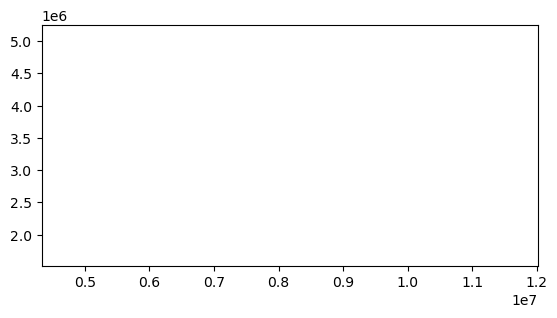

In [12]:
oceans_without_anthromes_gdf = gpd.overlay(world_boundaries_gdf,anthromes_land_regions_gdf,how='difference')
oceans_without_anthromes_gdf.plot()
oceans_without_anthromes_gdf

In [13]:
oceans_without_anthromes_gdf.to_crs(epsg=8857).is_valid.all()

True

C:\Users\Luke\AppData\Local\Temp\ipykernel_14960\1487963507.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dissolved_anthromes_with_oceans_gdf = anthromes_dissolved_gdf.append(oceans_without_anthromes_gdf).to_crs(epsg=8857)


<AxesSubplot:>

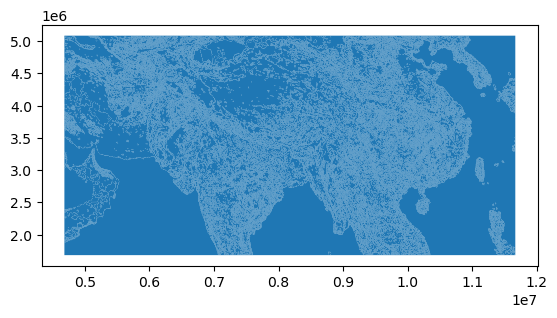

In [14]:
dissolved_anthromes_with_oceans_gdf = anthromes_dissolved_gdf.append(oceans_without_anthromes_gdf).to_crs(epsg=8857)
dissolved_anthromes_with_oceans_gdf.plot()

In [15]:
dissolved_anthromes_with_oceans_gdf.to_file("NACIS-2022/anthromes.gpkg", layer='anthromes', driver="GPKG")
dissolved_anthromes_with_oceans_gdf = gpd.read_file("NACIS-2022/anthromes.gpkg", layer='anthromes', driver="GPKG")
dissolved_anthromes_with_oceans_gdf.index.name = 'dissolved_id'
dissolved_anthromes_with_oceans_gdf.to_file("NACIS-2022/anthromes.gpkg", layer='anthromes', driver="GPKG")

c:\Users\Luke\Miniconda3\envs\geopandas_10_2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [16]:
dissolved_anthromes_with_oceans_gdf = gpd.read_file("NACIS-2022/anthromes.gpkg", layer='anthromes', driver="GPKG")
dissolved_anthromes_with_oceans_gdf.sindex
dissolved_anthromes_with_oceans_gdf = dissolved_anthromes_with_oceans_gdf.explode(index_parts = False, ignore_index = True)
dissolved_anthromes_with_oceans_gdf.sindex
dissolved_anthromes_with_oceans_gdf

,dissolved_id,1800AD,1900AD,2017AD,geometry
0,0,0,0,0,"POLYGON ((11665302.991 3364051.389, 11665086.1..."
1,0,0,0,0,"POLYGON ((11646940.644 4154293.689, 11641563.5..."
2,0,0,0,0,"POLYGON ((10348462.653 1704781.797, 10344935.8..."
3,0,0,0,0,"POLYGON ((11614811.020 1707112.118, 11611314.6..."
4,0,0,0,0,"POLYGON ((11662714.903 4237464.229, 11657313.7..."
...,...,...,...,...,...
42019,762,63,63,43,"POLYGON ((7576372.657 4628711.402, 7573332.616..."
42020,762,63,63,43,"POLYGON ((6671726.313 4483828.337, 6666121.837..."
42021,763,63,63,62,"POLYGON ((7593866.054 4495541.400, 7590843.543..."
42022,764,63,63,63,"POLYGON ((6697979.639 4424584.442, 6703512.473..."


In [17]:
dissolved_anthromes_with_oceans_gdf.dissolved_id = dissolved_anthromes_with_oceans_gdf.index
dissolved_anthromes_with_oceans_gdf

,dissolved_id,1800AD,1900AD,2017AD,geometry
0,0,0,0,0,"POLYGON ((11665302.991 3364051.389, 11665086.1..."
1,1,0,0,0,"POLYGON ((11646940.644 4154293.689, 11641563.5..."
2,2,0,0,0,"POLYGON ((10348462.653 1704781.797, 10344935.8..."
3,3,0,0,0,"POLYGON ((11614811.020 1707112.118, 11611314.6..."
4,4,0,0,0,"POLYGON ((11662714.903 4237464.229, 11657313.7..."
...,...,...,...,...,...
42019,42019,63,63,43,"POLYGON ((7576372.657 4628711.402, 7573332.616..."
42020,42020,63,63,43,"POLYGON ((6671726.313 4483828.337, 6666121.837..."
42021,42021,63,63,62,"POLYGON ((7593866.054 4495541.400, 7590843.543..."
42022,42022,63,63,63,"POLYGON ((6697979.639 4424584.442, 6703512.473..."


In [18]:
dissolved_anthromes_with_oceans_gdf.geometry.is_valid.all()

True

In [19]:
dissolved_anthromes_with_oceans_gdf.has_sindex

True

In [20]:
unit = TileUnit(
    #tiling_type = "hex-colouring", 
    tiling_type = "hex-dissection", n = 3, dissection_offset = 0,
    #  Note these alternatives:
    #  tiling_type = "hex-dissection", 
    #  tiling_type = "hex-dissection", dissection_offset = 0,
    #     n = 3, 
    crs = dissolved_anthromes_with_oceans_gdf.crs, 
    spacing = 100000).transform_rotate(15)
tiling = Tiling(unit, dissolved_anthromes_with_oceans_gdf, id_var = "dissolved_id", tile_margin = 5000)

tiling.tiles.to_file('NACIS-2022/anthromes-hex-dissection--100km--margin-10km-across--ragged--prioritise-tiles--data-subset--TILING_ONLY.gpkg')

c:\Users\Luke\Miniconda3\envs\geopandas_10_2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [21]:
# tiling.region.buffer(tiling.tile_unit.spacing).unary_union

In [22]:
map = tiling.get_tiled_map(ragged_edges=True,prioritise_tiles=True, tiles_or_elements = "tiles")
map.to_file('NACIS-2022/anthromes-hex-dissection--100km--margin-10km-across--ragged--prioritise-tiles--data-subset.gpkg')

c:\Users\Luke\Miniconda3\envs\geopandas_10_2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\Luke\Miniconda3\envs\geopandas_10_2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\Luke\Miniconda3\envs\geopandas_10_2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [23]:
map

TiledMap(tiling=Tiling(tile_unit=TileUnit(elements=  element_id                                           geometry
0          a  POLYGON ((50190.978 13448.632, 36742.346 -3674...
1          b  POLYGON ((-36742.346 36742.346, 13448.632 5019...
2          c  POLYGON ((-13448.632 -50190.978, -50190.978 -1..., tile=                                            geometry
0  POLYGON ((40824.829 -40824.829, 55767.754 1494..., spacing=100000, tile_shape=<TileShape.HEXAGON: 'hexagon'>, vectors=[(-25881.904510252076, 96592.58262890684), (-96592.58262890682, 25881.904510252083), (-70710.67811865476, -70710.67811865475), (25881.904510252032, -96592.58262890684), (96592.58262890684, -25881.904510252083), (70710.67811865479, 70710.67811865475)], regularised_tile=                                            geometry
0  POLYGON ((40824.829 -40824.829, 55767.754 1494..., crs=<Derived Projected CRS: EPSG:8857>
Name: WGS 84 / Equal Earth Greenwich
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]:

In [24]:
this will cause an error

SyntaxError: invalid syntax (2309815648.py, line 1)

/home/osullid3/anaconda3/envs/weaving/lib/python3.10/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/home/osullid3/anaconda3/envs/weaving/lib/python3.10/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 1
  Warn("Warning: setting k to %d" % k_q, UserWarning)


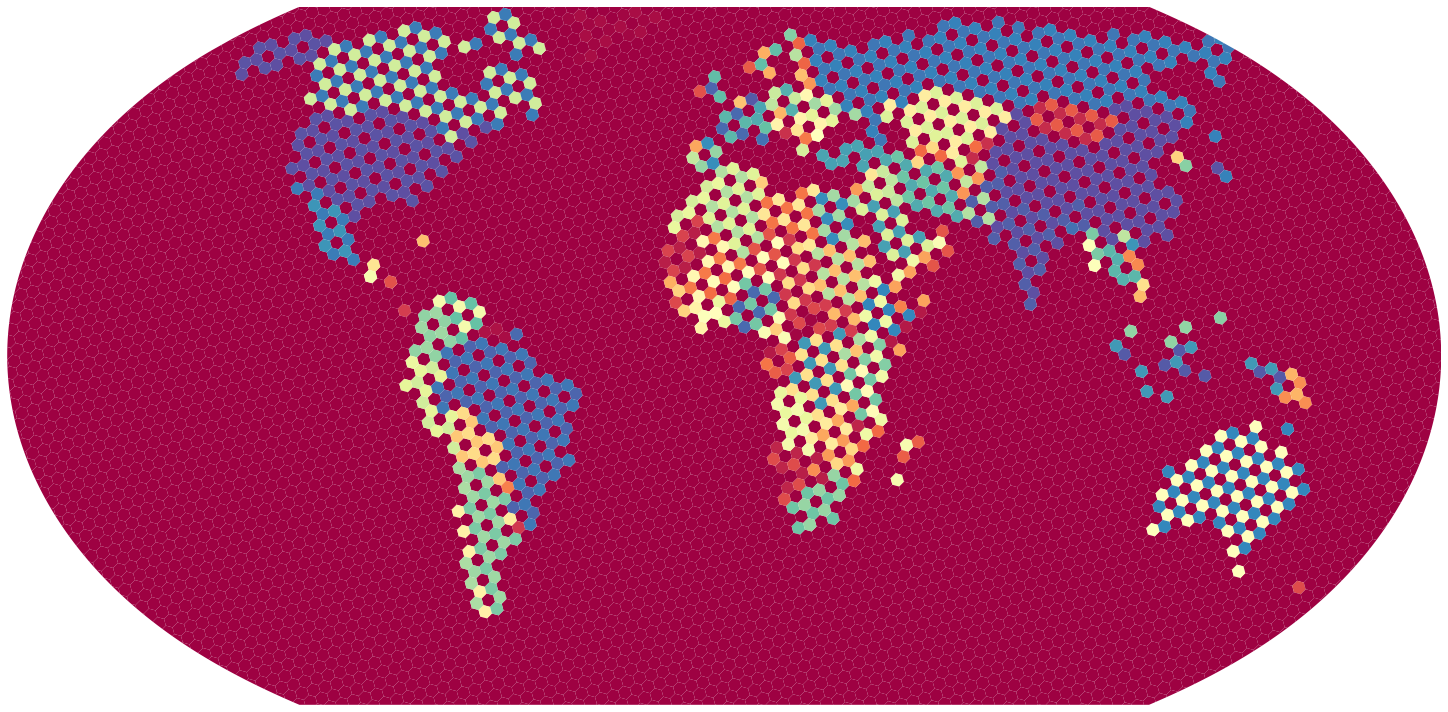

In [ ]:
map.variables = dict(zip(list("abc"),
                        ("1800AD", "1900AD", "2017AD")))
map.colourmaps = dict(zip(map.variables.values(), 
                         ("Spectral", "Spectral", "Spectral")))

fig = map.render(legend = False, scheme = "quantiles") # quantiles for interest

/home/osullid3/anaconda3/envs/weaving/lib/python3.10/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/home/osullid3/anaconda3/envs/weaving/lib/python3.10/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 1
  Warn("Warning: setting k to %d" % k_q, UserWarning)


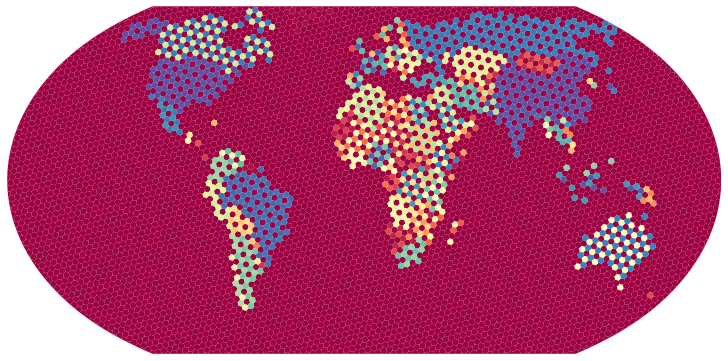

In [ ]:
map.dpi = 600  # don't ask me what makes sense for DPI
map.figsize = (10, 7)

fig = map.render(legend = False, scheme = "quantiles")

In [ ]:
fig.savefig("NACIS-2022/output/another-map.svg")